In [ ]:
!pip install gdown

In [11]:
# Replace 'YOUR_FILE_ID' with the actual ID from your Google Drive link
# Replace 'your_downloaded_file.zip' with the desired name for your downloaded zip file
# https://drive.google.com/file/d/19XgsqWaljZ7J0NFf2FtM50DlGhQKCcAg/view?usp=drive_link
!gdown --id 19XgsqWaljZ7J0NFf2FtM50DlGhQKCcAg -O data.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19XgsqWaljZ7J0NFf2FtM50DlGhQKCcAg
From (redirected): https://drive.google.com/uc?id=19XgsqWaljZ7J0NFf2FtM50DlGhQKCcAg&confirm=t&uuid=d4d397a0-ae24-4879-8e3c-238ac7ed26e6
To: /content/data.zip
100% 2.74G/2.74G [00:23<00:00, 116MB/s]


After downloading, you can unzip the file:

In [12]:
# Replace 'your_downloaded_file.zip' with the name of your downloaded zip file
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/val/COCO_val2014_000000010138.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000010138.png  
  inflating: data/val/COCO_val2014_000000546823.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000546823.png  
  inflating: data/val/COCO_val2014_000000330536.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000330536.png  
  inflating: data/val/COCO_val2014_000000466259.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000466259.png  
  inflating: data/val/COCO_val2014_000000005535.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000005535.png  
  inflating: data/val/COCO_val2014_000000224557.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000224557.png  
  inflating: data/val/COCO_val2014_000000083036.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000083036.png  
  inflating: data/val/COCO_val2014_000000008005.png  
  inflating: __MACOSX/data/val/._COCO_val2014_000000008005.png

In [ ]:
!unzip /content/data.zip

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.


## 1. Pre-processing Function and Generator


### 1.0 Pre-processing Function

**Pre-Process Images**: Converts Input Images to 4:3 ration and use padding function for padding zeros. and it also pre-process for VGG-16 Architure substracting Mean from all channels.

**Pre-Process Maps**: Converts Output Images (Saliency Maps) to 4:3 ration and use padding function for padding zeros. and it also convert gray scale range of 0-255 to 0-1.

Note: pre-process, pre-process maps and padding are taken from reference code.

In [13]:
import cv2
import numpy as np

def padding(img, shape_r=480, shape_c=640, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded


def preprocess_images(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), shape_r, shape_c, 3))

    for i, path in enumerate(paths):
        original_image = cv2.imread(path)
        padded_image = padding(original_image, shape_r, shape_c, 3)
        ims[i] = padded_image.astype('float')

#     cv2 : BGR
#     PIL : RGB
    ims = ims[...,::-1]
    ims /= 255.0
    ims = np.rollaxis(ims, 3, 1)
    return ims


def preprocess_maps(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), 1, shape_r, shape_c))

    for i, path in enumerate(paths):
        original_map = cv2.imread(path, 0)
        padded_map = padding(original_map, shape_r, shape_c, 1)
        ims[i, 0] = padded_map.astype(np.float32)
        ims[i, 0] /= 255.0


    return ims

### 1.1 Generator

**generator**: It is used to supply images during training/testing with specified batch sizes. Function is modified from reference code. Shuffle and breaking condition of loop is added.

In [14]:
import os
from sklearn.utils import shuffle

imgs_train_path = 'images/'
maps_train_path = 'train/'

imgs_val_path = 'val_images/'
maps_val_path = 'val/'



def generator(b_s, phase_gen='train'):
    if phase_gen == 'train':
        images = [imgs_train_path + f for f in os.listdir(imgs_train_path) if f.endswith('.jpg')]
        maps = [maps_train_path + f for f in os.listdir(maps_train_path) if f.endswith('.png')]
    elif phase_gen == 'val':
        images = [imgs_val_path + f for f in os.listdir(imgs_val_path) if f.endswith('.jpg')]
        maps = [maps_val_path + f for f in os.listdir(maps_val_path) if f.endswith('.png')]
    else:
        raise NotImplementedError

    images.sort()
    maps.sort()

    images , maps = shuffle(images,maps)

    counter = 0

    while True:
        yield preprocess_images(images[counter:counter + b_s], shape_r, shape_c), preprocess_maps(maps[counter:counter + b_s], shape_r_gt, shape_c_gt)
        if counter + b_s >= len(images):
          break
        counter = counter + b_s

## 2. Defining Model and Loss Function

### 2.1 Installing PyTorch

In [15]:
# installing pytorch and pytorch vision
!pip3 install torchvision

### 2.2 Defining Model

More Detail of Model in Paper : https://arxiv.org/abs/1609.01064

![Model](https://raw.githubusercontent.com/marcellacornia/mlnet/master/figs/mlnet.jpg)

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models


class MLNet(nn.Module):

    def __init__(self,prior_size):
        super(MLNet, self).__init__()
        # loading pre-trained vgg16 model and
        # removing last max pooling layer
        features = list(models.vgg16(pretrained = True).features)[:-1]

        # making same spatial size
        # by calculation :)
        # in pytorch there was problem outputing same size in maxpool2d
        features[23].stride = 1
        features[23].kernel_size = 5
        features[23].padding = 2

        self.features = nn.ModuleList(features).eval()
        # adding dropout layer
        self.fddropout = nn.Dropout2d(p=0.5)
        # adding convolution layer to down number of filters 1280 ==> 64
        self.int_conv = nn.Conv2d(1280,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pre_final_conv = nn.Conv2d(64,1,kernel_size=(1, 1), stride=(1, 1) ,padding=(0, 0))
        # prior initialized to ones
        self.prior = nn.Parameter(torch.ones((1,1,prior_size[0],prior_size[1]), requires_grad=True))

        # bilinear upsampling layer
        self.bilinearup = torch.nn.UpsamplingBilinear2d(scale_factor=10)

    def forward(self, x):

        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {16,23,29}:
                results.append(x)

        # concat to get 1280 = 512 + 512 + 256
        x = torch.cat((results[0],results[1],results[2]),1)

        # adding dropout layer with dropout set to 0.5 (default)
        x = self.fddropout(x)

        # 64 filters convolution layer
        x = self.int_conv(x)
        # 1*1 convolution layer
        x = self.pre_final_conv(x)

        upscaled_prior = self.bilinearup(self.prior)
        # print ("upscaled_prior shape: {}".format(upscaled_prior.shape))

        # dot product with prior
        x = x * upscaled_prior
        x = torch.nn.functional.relu(x,inplace=True)
        return x


### 2.3 Defining Custom Loss function derived From MSE Loss

In [17]:
# Modified MSE Loss Function
class ModMSELoss(torch.nn.Module):
    def __init__(self,shape_r_gt,shape_c_gt):
        super(ModMSELoss, self).__init__()
        self.shape_r_gt = shape_r_gt
        self.shape_c_gt = shape_c_gt

    def forward(self, output , label , prior):
        prior_size = prior.shape
        output_max = torch.max(torch.max(output,2)[0],2)[0].unsqueeze(2).unsqueeze(2).expand(output.shape[0],output.shape[1],self.shape_r_gt,self.shape_c_gt)
        reg = ( 1.0/(prior_size[0]*prior_size[1]) ) * ( 1 - prior)**2
        loss = torch.mean( ((output / output_max) - label)**2 / (1 - label + 0.1) )  +  torch.sum(reg)
        return loss

## 3. Training Model

#### Memory Warning:

This model require huge amount of memory. Paper doesn't freeze any layer and uses configratution of Image size = (480,640) , batch_size = 10.
Training with default configration result into cuda out of memory (12 GB of GPU RAM).

To tackle this problem, I have tried to train model on two variant.
> 1.

       shape_r = 240 ==> shape_r_gt = 30
       shape_c = 320 ==> shape_c_gt = 40
       batch_size = 16
       last_freeze_layer = 23
> 2.

       shape_r = 480 ==> shape_r_gt = 60
       shape_c = 640 ==> shape_c_gt = 80
       batch_size = 16
       last_freeze_layer = 28
       
       
**Note : Second Approch didn't perform well.**

#### Prior Size:

prior size (w',h') where w' << w and h' << h as mentioned in paper where w,h are width and height of output.

**w' =  w  / 10**

**h'  =  h  / 10**


In [18]:
# Input Images size
shape_r = 240
shape_c = 320
# shape_r = 480
# shape_c = 640

# Output Image size (generally divided by 8 from Input size)
shape_r_gt = 30
shape_c_gt = 40
# shape_r_gt = 60
# shape_c_gt = 80


last_freeze_layer = 23
# last_freeze_layer = 28

In [19]:
prior_size = ( int(shape_r_gt / 10) , int(shape_c_gt / 10) )

model = MLNet(prior_size).cuda()


# freezing Layer
for i,param in enumerate(model.parameters()):
  if i < last_freeze_layer:
    param.requires_grad = False


criterion = ModMSELoss(shape_r_gt,shape_c_gt).cuda()

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,weight_decay=0.0005,momentum=0.9,nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


In [20]:

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
import time
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

loss_history = []
nb_epochs = 10
batch_size = 16

for epoch in range(nb_epochs):
  t1 = time.time()
  image_trained = 0

  for i,gt_map in generator(batch_size):

      optimizer.zero_grad()
#       print (i.shape)

      i,gt_map = torch.tensor(i.copy(),dtype=torch.float),torch.tensor(gt_map,dtype=torch.float)
      for idx,x in enumerate(i):
        i[idx] = normalize(x)
      i,gt_map = i.cuda(),gt_map.cuda()

      image_trained += batch_size

      out = model.forward(i)
      loss = criterion(out,gt_map,model.prior.clone())
      loss.backward()
      optimizer.step()

      if image_trained % (batch_size*20) == 0:
        print ("Epcohs:{} Images:{} Loss:{}".format(epoch,image_trained,loss.item()) )
  t2 = time.time()
  time_per_epoch = (t2 - t1) / 60.0
  print ('Time taken for epoch-{} : {}m'.format(epoch,time_per_epoch))

Epcohs:0 Images:320 Loss:0.042131274938583374
Epcohs:0 Images:640 Loss:0.03471488133072853
Epcohs:0 Images:960 Loss:0.021858910098671913
Epcohs:0 Images:1280 Loss:0.029107650741934776
Epcohs:0 Images:1600 Loss:0.028235645964741707
Epcohs:0 Images:1920 Loss:0.015504204668104649
Epcohs:0 Images:2240 Loss:0.026208840310573578
Epcohs:0 Images:2560 Loss:0.028491158038377762
Epcohs:0 Images:2880 Loss:0.01502612791955471
Epcohs:0 Images:3200 Loss:0.015005300752818584
Epcohs:0 Images:3520 Loss:0.01889006979763508
Epcohs:0 Images:3840 Loss:0.017480885609984398
Epcohs:0 Images:4160 Loss:0.020509392023086548
Epcohs:0 Images:4480 Loss:0.018869619816541672
Epcohs:0 Images:4800 Loss:0.027569390833377838
Epcohs:0 Images:5120 Loss:0.030155150219798088
Epcohs:0 Images:5440 Loss:0.024341506883502007
Epcohs:0 Images:5760 Loss:0.01751537062227726
Epcohs:0 Images:6080 Loss:0.023098701611161232
Epcohs:0 Images:6400 Loss:0.017314588651061058
Epcohs:0 Images:6720 Loss:0.020546341314911842
Epcohs:0 Images:7040

## 4. Visualizing Model Output  and Saving Model Weights

### 4.0 Visualizing Model output on Validation Images
Note :Each Time running code will output different Image visualization

In [22]:
# loading saved model to visualize
!gdown https://drive.google.com/uc?id=1vhA5Uc547nZL0rI9IsHWEbhx2j-oSnrn&export=download
# PATH = "2018-10-04 09_20_57.364231_5_epochs_v1.model"
# model.load_state_dict(torch.load(PATH))

Downloading...
From: https://drive.google.com/uc?id=1vhA5Uc547nZL0rI9IsHWEbhx2j-oSnrn
To: /content/2018-10-04 09_20_57.364231_5_epochs_v1.model
100% 61.8M/61.8M [00:00<00:00, 93.6MB/s]


Original
(240, 320, 3)


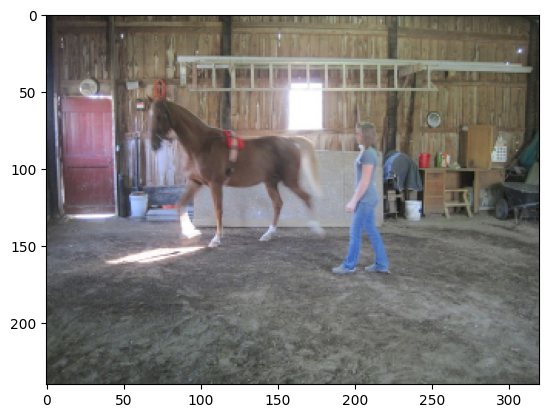

predicted


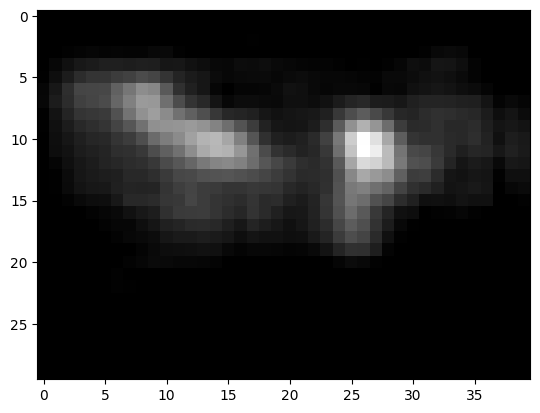

Original


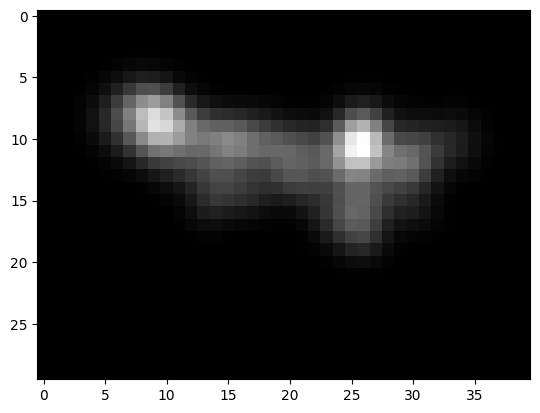

Original
(240, 320, 3)


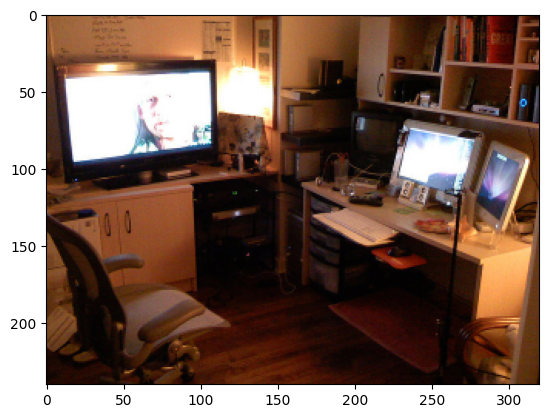

predicted


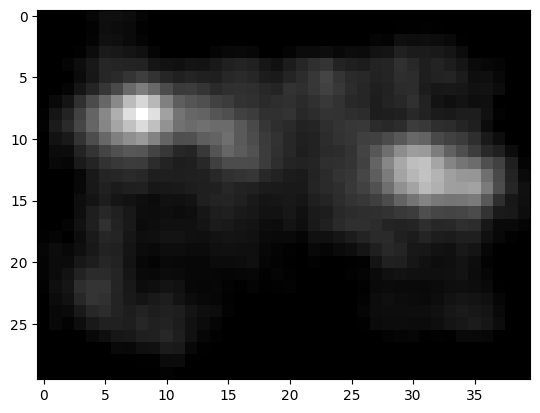

Original


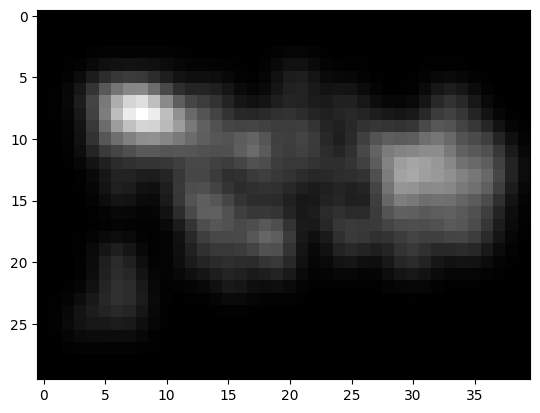

Original
(240, 320, 3)


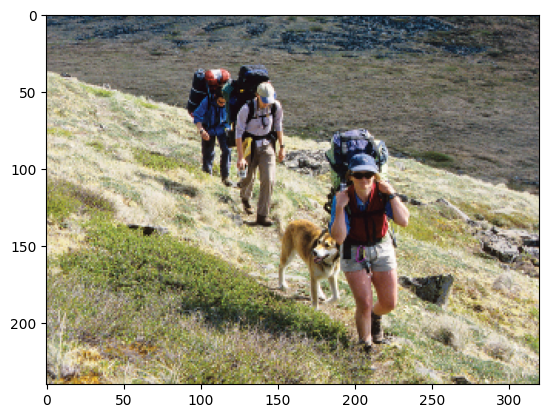

predicted


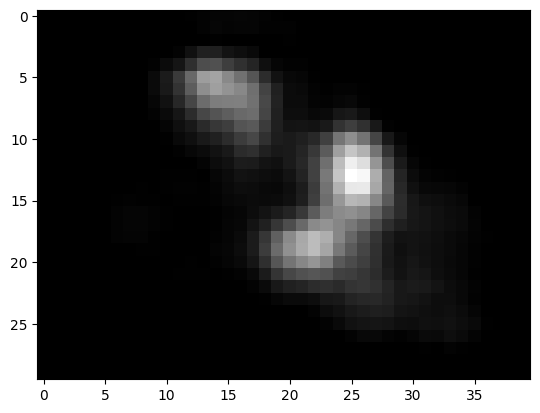

Original


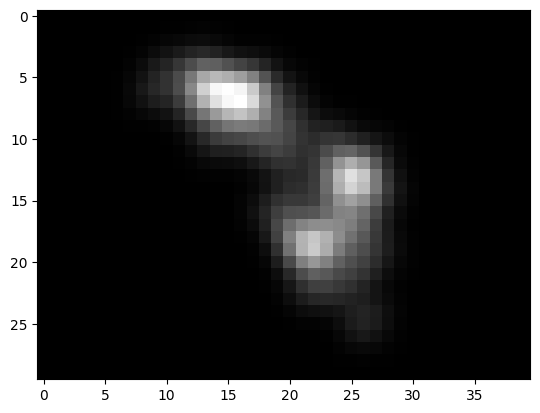

Original
(240, 320, 3)


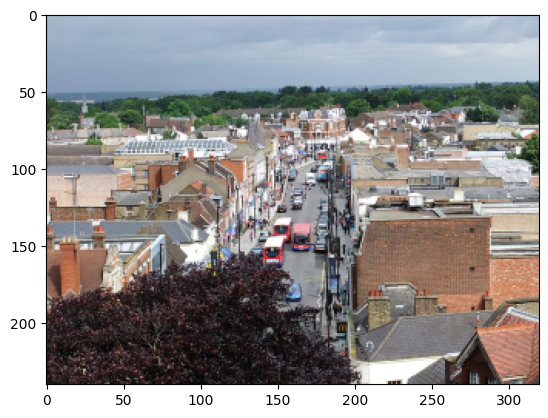

predicted


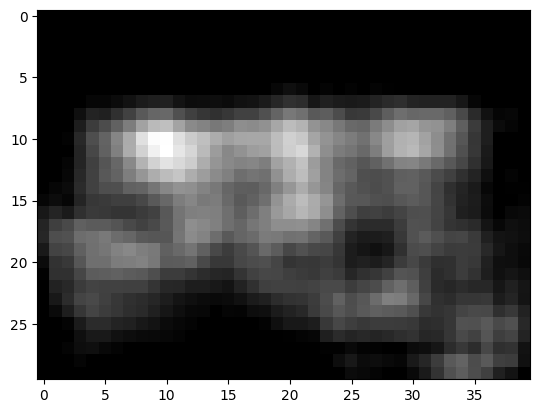

Original


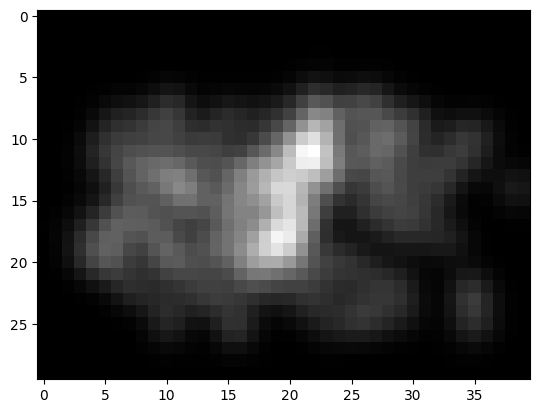

Original
(240, 320, 3)


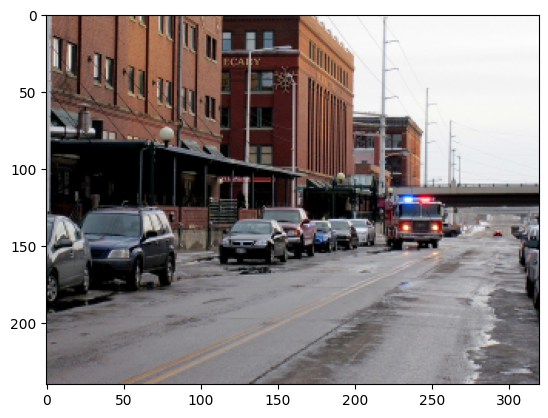

predicted


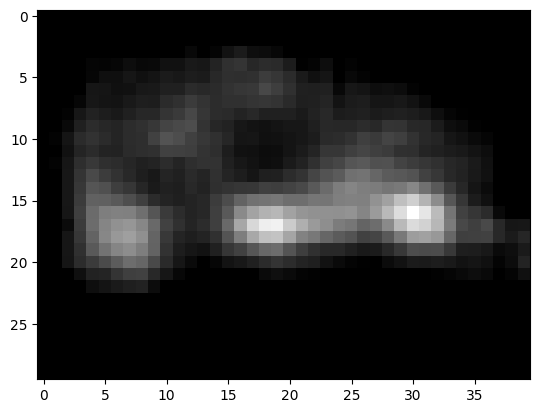

Original


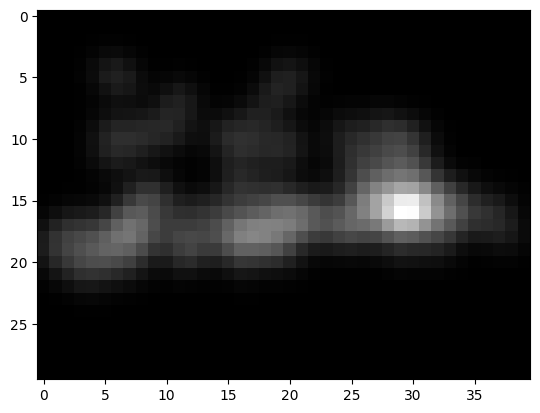

Original
(240, 320, 3)


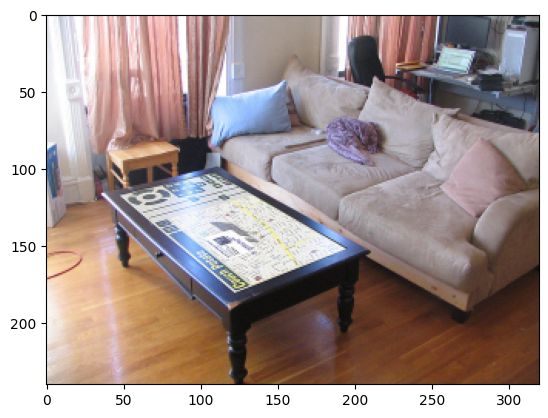

predicted


Original


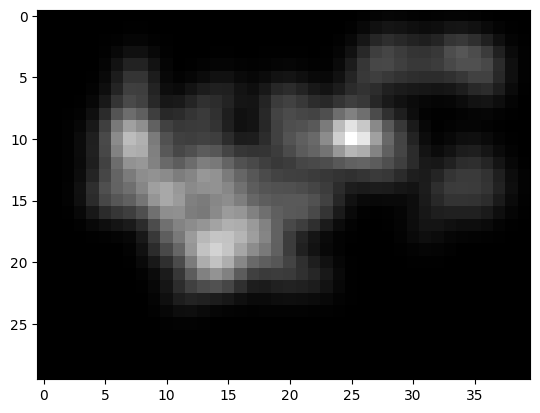

Original
(240, 320, 3)


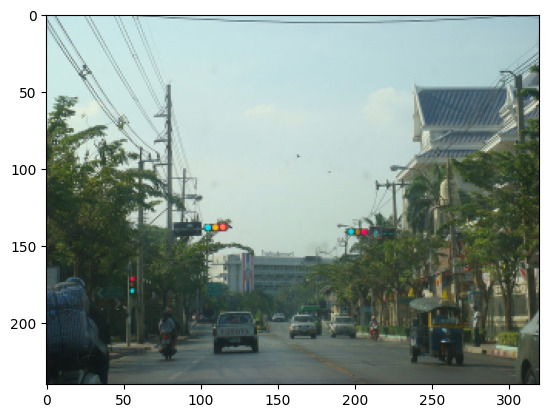

predicted


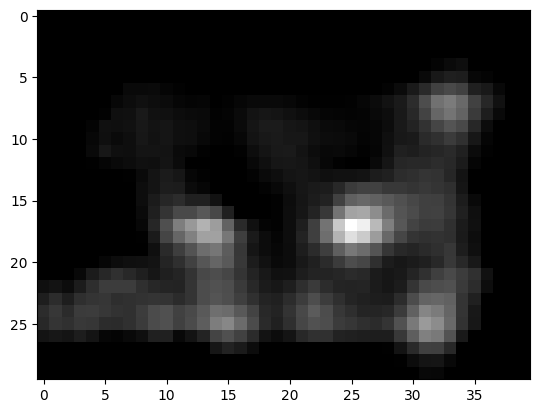

Original


Original
(240, 320, 3)


predicted


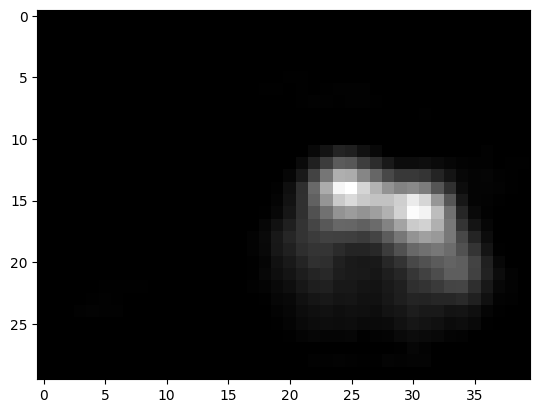

Original


Original
(240, 320, 3)


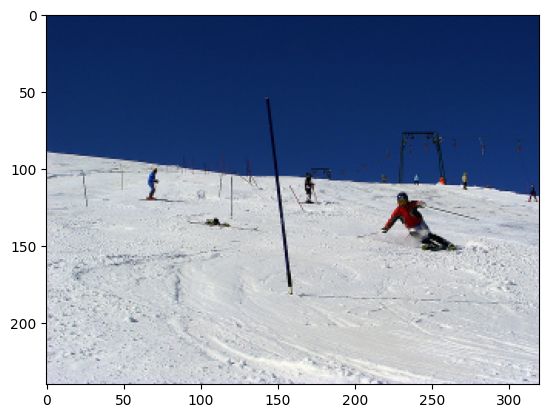

predicted


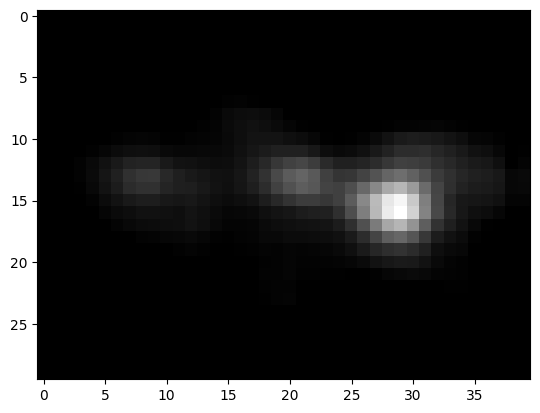

Original


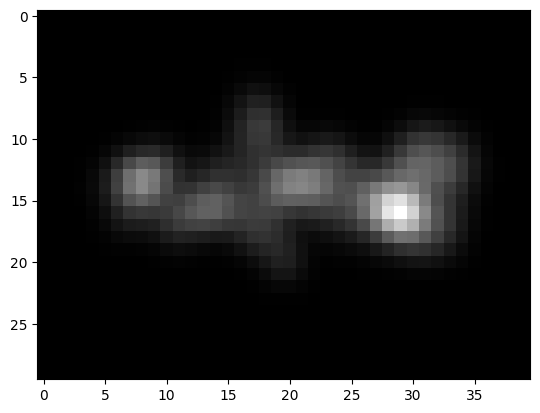

Original
(240, 320, 3)


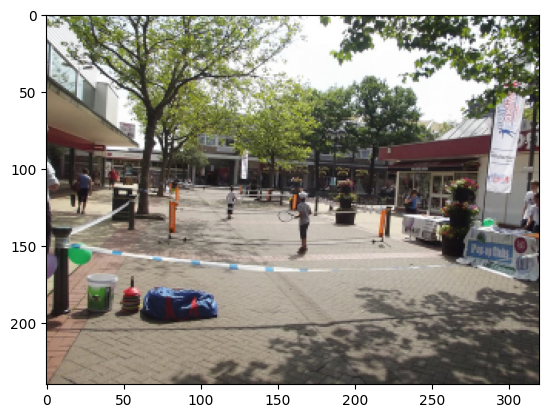

predicted


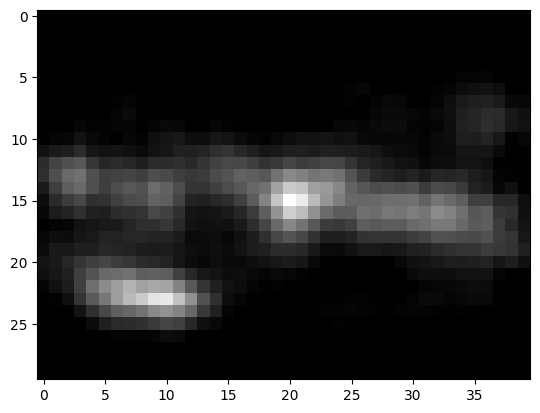

Original


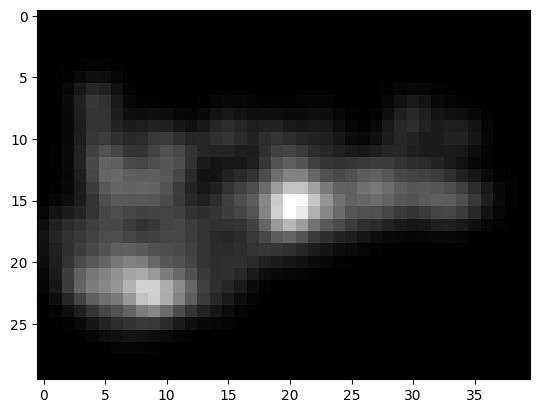

Original
(240, 320, 3)


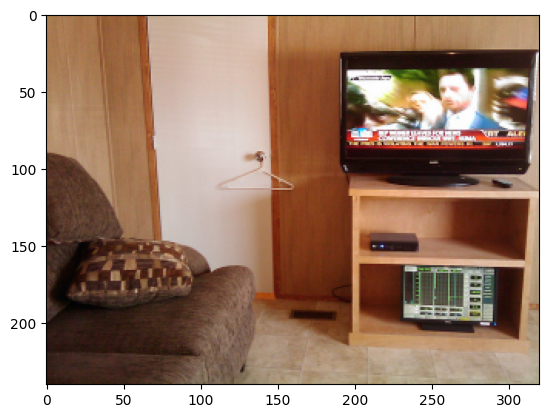

predicted


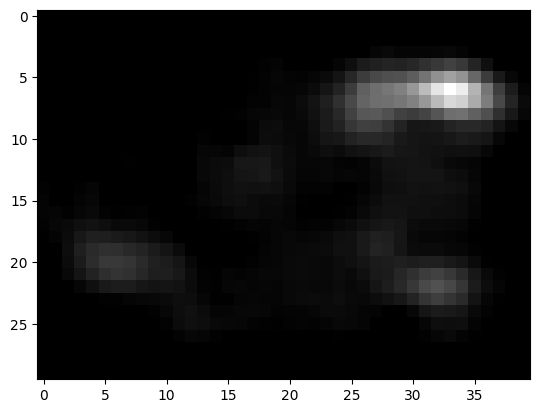

Original


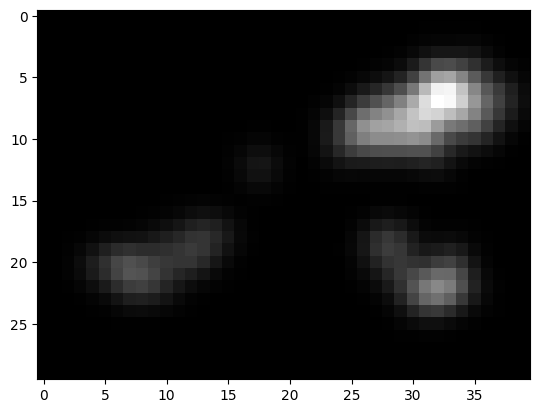

Original
(240, 320, 3)


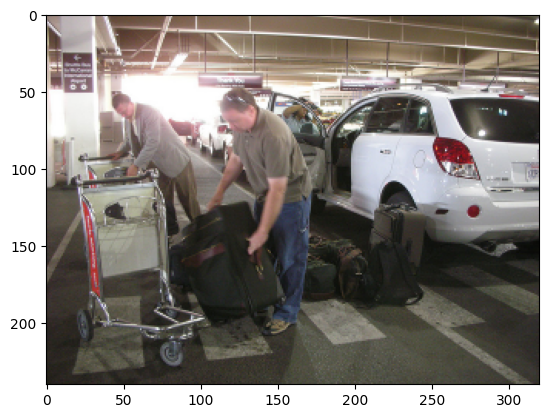

predicted


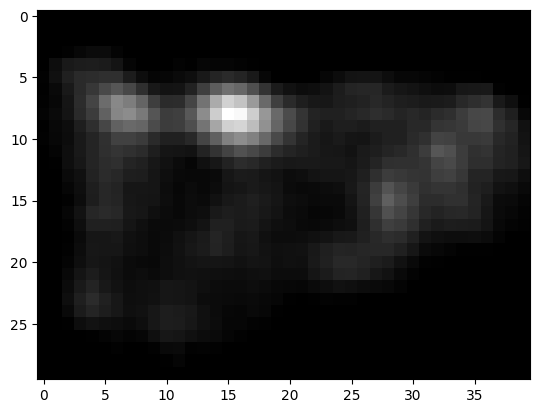

Original


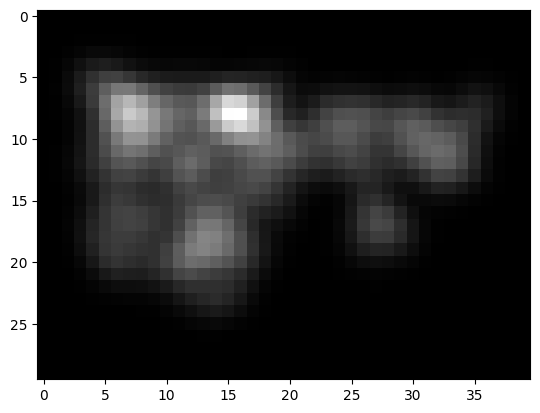

Original
(240, 320, 3)


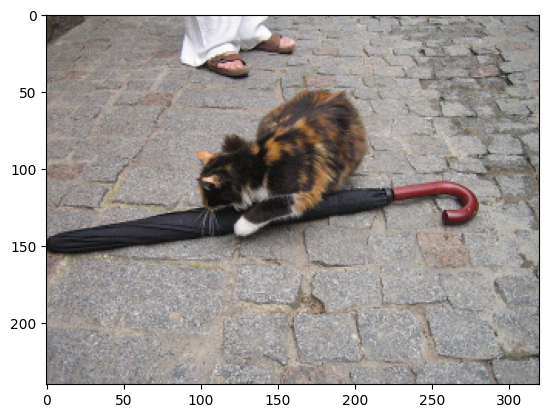

predicted


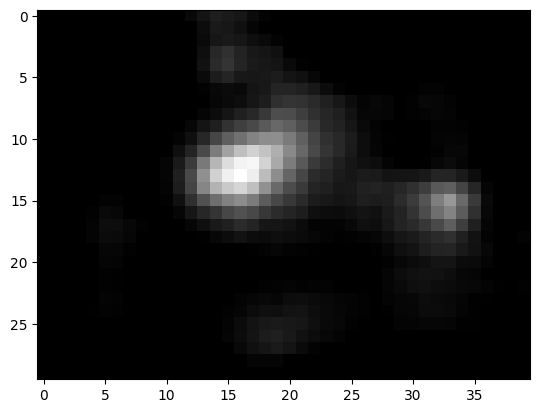

Original


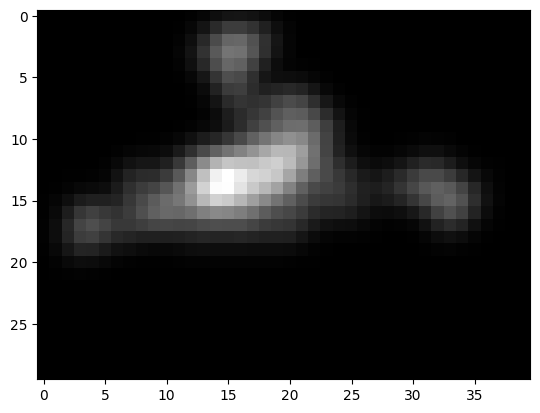

Original
(240, 320, 3)


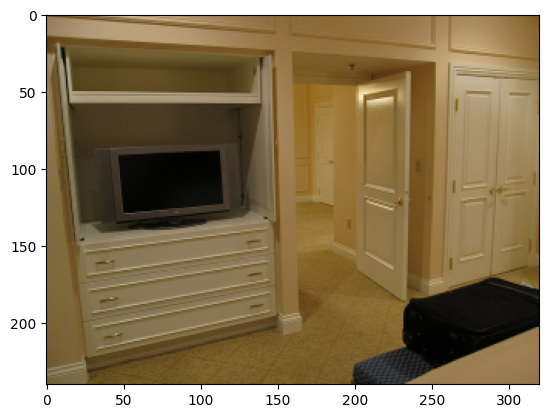

predicted


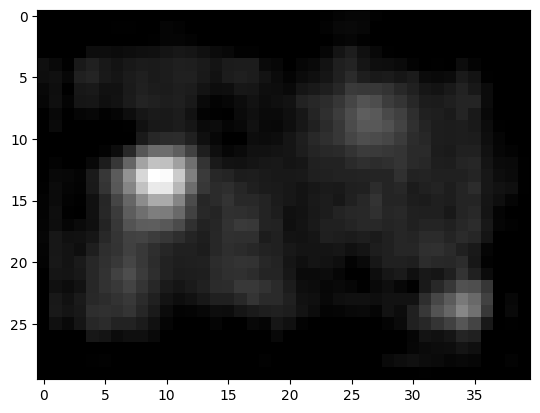

Original


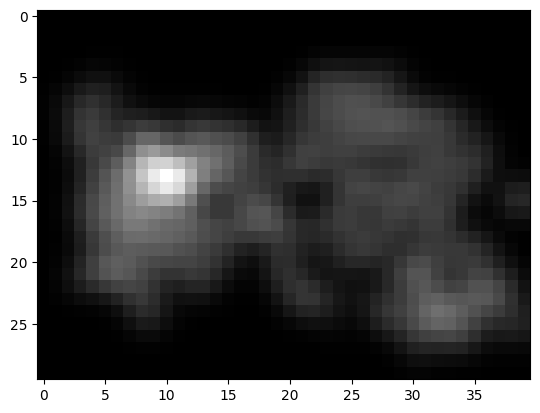

Original
(240, 320, 3)


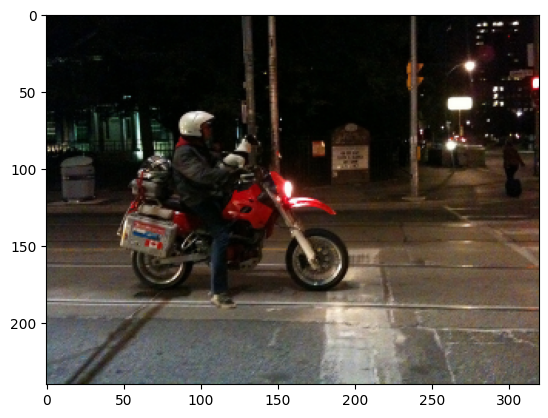

predicted


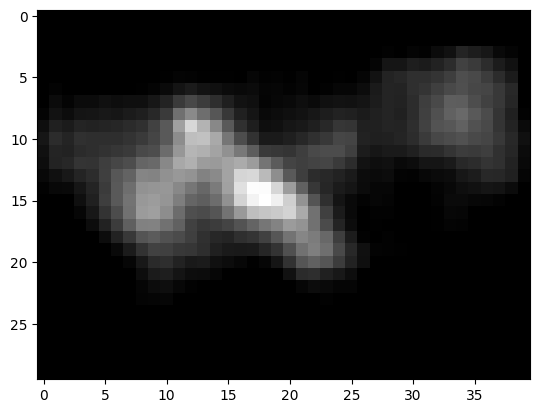

Original


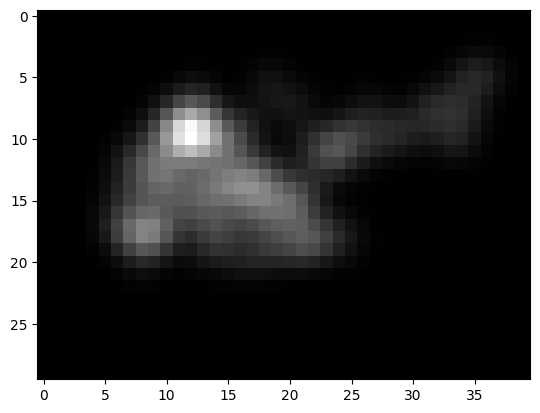

Original
(240, 320, 3)


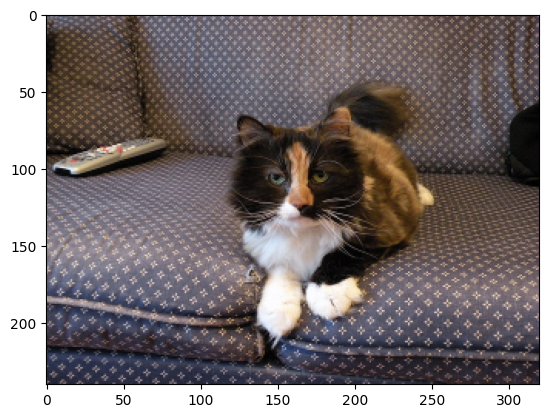

predicted


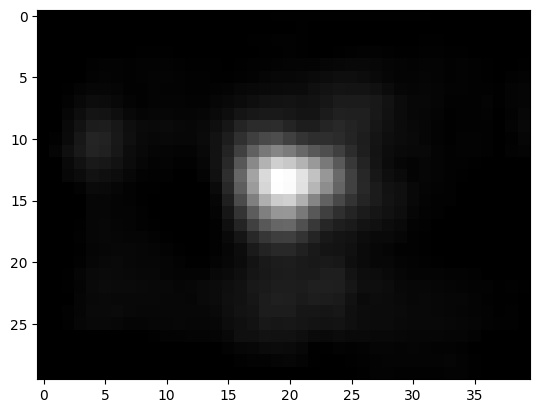

Original


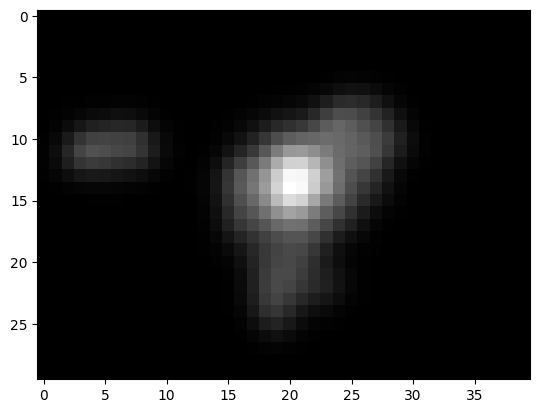

In [25]:
import matplotlib.pyplot as plt

# how many pic you want to visualiz at randomly
no_visual = 15


visual_cnt = 0
for i,gt_map in generator(1,phase_gen='val'):
    print ("Original")
    org_image = i[0].copy()

    org_image = np.rollaxis(org_image, 0, 3)
    print (org_image.shape)
    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    out = model.forward(i)
    # adding term which were subtracted at pre processing
    plt.imshow(org_image)
    plt.show()
    print ("predicted")
    plt.imshow(out[0].squeeze(0).data.cpu().numpy(),cmap='gray')
    plt.show()
    print ("Original")
    plt.imshow(gt_map[0][0],cmap='gray')
    plt.show()
    visual_cnt += 1
    if visual_cnt > no_visual:
      break

### 4.1 Saving Model

Note: Weight file can be downloaded using File section at left.

In [23]:
# creatin Dir for saving model
!mkdir saved_models -p


import time
import datetime

# saving model weight
additional_info = 'saliency'
full_path = 'saved_models/' + str(datetime.datetime.now()) + '_' + additional_info + '.model'
torch.save(model.state_dict(), full_path)

# for loading Model
# model.load_state_dict(torch.load(PATH))


In [24]:
from google.colab import files
files.download(full_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5.0 Run Model on a Single Image

To run the model on your own image, first, you need to upload it to your Colab environment. You can use the `files.upload()` function for this.

In [ ]:
from google.colab import files
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Upload your image file
print("Please upload an image file.")
uploaded = files.upload()

# Get the filename of the uploaded image
for fn in uploaded.keys():
  img_filename = fn

print(f'User uploaded file "{img_filename}" ({len(uploaded[img_filename])} bytes)')

Now, we will load, preprocess, and run inference on the uploaded image. The output saliency map will be displayed below.

In [ ]:
# Define the image path
image_path = f'./{img_filename}'

# Preprocess the image using the defined function
# Note: preprocess_images expects a list of paths
input_image_tensor = preprocess_images([image_path], shape_r, shape_c)

# Store a copy of the original (preprocessed but not normalized) image for display
org_image_display = np.rollaxis(input_image_tensor[0].copy(), 0, 3)

# Convert to PyTorch tensor and normalize
input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Apply normalization
for idx, x in enumerate(input_image_tensor):
  input_image_tensor[idx] = normalize(x)

# Move to CUDA if available
input_image_tensor = input_image_tensor.cuda()

# Ensure model is in evaluation mode
model.eval()

# Run inference
with torch.no_grad():
    output_saliency_map = model.forward(input_image_tensor)

# Post-process the output for visualization
# Convert to CPU, squeeze dimensions, and convert to numpy array
saliency_map_np = output_saliency_map[0].squeeze(0).data.cpu().numpy()

# Display the original image and the predicted saliency map
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(org_image_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map_np, cmap='gray')
plt.title("Predicted Saliency Map")
plt.axis('off')

plt.show()

# Set model back to train mode if you plan to continue training
model.train()

## 5. Creating Submission.zip for submitting to CodaLab

In [ ]:
# # creating dir for storing prediction of test images
# ! mkdir test_maps

In [ ]:
# test_file = [ f for f in os.listdir('test_images/') if f.endswith('.jpg') ]

# for i in test_file:
#     img = preprocess_images(['test_images/'+i],shape_r,shape_c)
#     img = torch.tensor(img.copy(),dtype=torch.float)
#     for idx,x in enumerate(img):
#         img[idx] = normalize(x)
#     img = img.cuda()
#     pred = model.forward(img)
#     cv2.imwrite('test_maps/' + i[:-3] + 'png',pred[0].squeeze(0).data.cpu().numpy())

In [ ]:
# # generatung Submission.zip
# ! cd test_maps ; zip ../submission.zip *.png > zipping.log